In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from scipy.stats import ttest_ind
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from sklearn.linear_model import Ridge

In [2]:
data = pd.read_csv('/Users/riyamhatre/Desktop/cleaned_data.csv').drop(columns = {'Unnamed: 0'})

<ipython-input-2-b93c3f3a4691>:1: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('/Users/riyamhatre/Desktop/cleaned_data.csv').drop(columns = {'Unnamed: 0'})


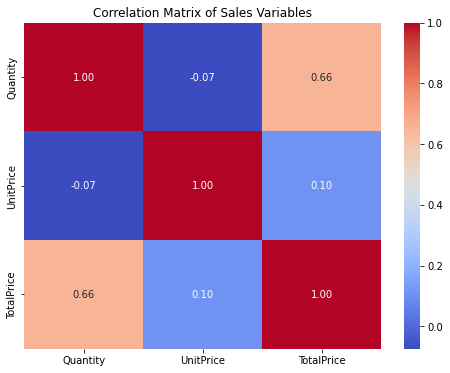

In [3]:
# Correlation Analysis
correlation_matrix = data[['Quantity', 'UnitPrice', 'TotalPrice']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Sales Variables')
plt.show()

In [4]:
# Create customer-level data
customer_data = data.groupby('CustomerID').agg({
    'InvoiceNo': 'nunique',  # Number of unique purchases
    'Quantity': 'sum',       # Total quantity purchased
    'TotalPrice': 'sum',     # Total revenue
}).reset_index()

# Regression: Total revenue vs. purchase frequency and total quantity
X = customer_data[['InvoiceNo', 'Quantity']]
y = customer_data['TotalPrice']

# Train-test split and regression
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)
print("R-squared:", r2_score(y_test, y_pred))
print("Coefficients:", model.coef_)

R-squared: 0.7782867651096752
Coefficients: [45.26564377  1.63248646]


An R-squared of 0.778 means that 77.8% of the variation in TotalPrice (total revenue per customer) is explained by the number of unique purchases (InvoiceNo) and the total quantity purchased (Quantity).
This is a relatively high value, suggesting that the chosen predictors are good at explaining customer spending behavior.

In [5]:
# Does the presence of a holiday affect revenue
data["Returned"] = data["Returned"].replace({True: 1, False: 0})
holiday_revenue = data[data['Holiday'].isna() == True]['TotalPrice']
non_holiday_revenue = data[data['Holiday'].isna() == False]['TotalPrice']

t_stat, p_value = ttest_ind(holiday_revenue, non_holiday_revenue)

print("t-statistic:", t_stat)
print("p-value:", p_value)

t-statistic: -0.38750621306601923
p-value: 0.6983816392159747


The p-value suggests no statistically significant difference between the revenue on holidays and non-holidays.
In practical terms, this means that whether it's a holiday or not does not have a meaningful impact on the revenue in your dataset.
The negative t-statistic further indicates that the mean revenue on holidays might be slightly lower than on non-holidays, but the difference is so small that it's likely due to random variation in the data.

In [6]:
# Does the presence of a holiday affect number of products purchased?
holiday_quantity = data[data['Holiday'].isna() == True]['Quantity']
non_holiday_quantity = data[data['Holiday'].isna() == False]['Quantity']

t_stat, p_value = ttest_ind(holiday_quantity, non_holiday_quantity)

print("t-statistic:", t_stat)
print("p-value:", p_value)

t-statistic: 2.4725328495241397
p-value: 0.013416244581234095


The result suggests that holidays have a positive impact on quantity, and this effect is statistically significant.
Businesses likely experience a noticeable increase in purchase frequency on holidays compared to regular days.

## Customer Segmentation

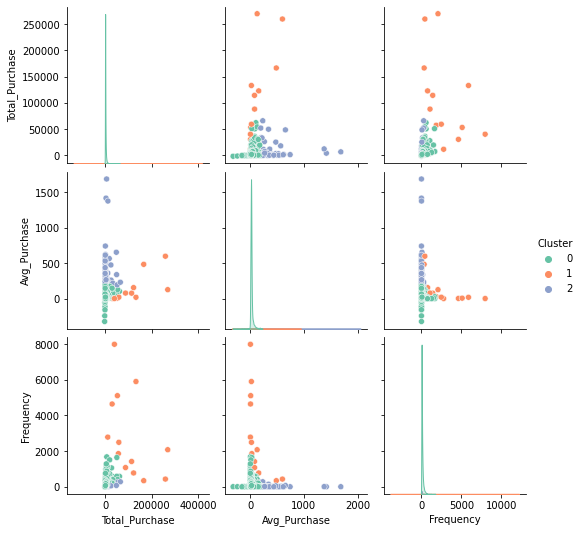

   Cluster  Avg_Total_Purchase  Total_Purchase  Avg_Purchase  Avg_Frequency  \
0        0         1469.977466     6297383.464     21.782194      85.904062   
1        1       108166.966923     1406170.570    126.276486    2836.000000   
2        2         8049.931967      491045.850    414.742226      27.426230   

   Avg_Returns  Customer_Count  
0     1.837302            4284  
1    65.615385              13  
2     1.721311              61  


In [7]:
# Aggregating customer metrics for clustering
customer_features = data.groupby('CustomerID').agg({
    'TotalPrice': ['sum', 'mean'],      # Total and Average Purchase
    'InvoiceNo': 'count',              # Frequency of Purchases
    'Returned': 'sum',                 # Total Returns
    'Region': 'first'                  # Retain region for reference
}).reset_index()

# Flatten column names
customer_features.columns = ['CustomerID', 'Total_Purchase', 'Avg_Purchase', 'Frequency', 'Returns', 'Region']

# Fill any missing values (e.g., Returns may have NaN for customers without returns)
customer_features.fillna(0, inplace=True)

# Normalize the numerical features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(customer_features[['Total_Purchase', 'Avg_Purchase', 'Frequency', 'Returns']])

# Perform K-Means Clustering
kmeans = KMeans(n_clusters=3, random_state=42)
customer_features['Cluster'] = kmeans.fit_predict(scaled_features)

# Visualize Clusters using Pairplot
sns.pairplot(customer_features, vars=['Total_Purchase', 'Avg_Purchase', 'Frequency'], hue='Cluster', palette='Set2')
plt.show()

# Analyze Each Cluster
cluster_analysis = customer_features.groupby('Cluster').agg({
    'Total_Purchase': ['mean', 'sum'],
    'Avg_Purchase': 'mean',
    'Frequency': 'mean',
    'Returns': 'mean',
    'CustomerID': 'count'
}).reset_index()

# Rename columns for readability
cluster_analysis.columns = ['Cluster', 'Avg_Total_Purchase', 'Total_Purchase', 'Avg_Purchase', 'Avg_Frequency', 'Avg_Returns', 'Customer_Count']
print(cluster_analysis)

In [8]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Month,CombinedDate,Holiday,TotalPrice,Day,DayofWeek,Returned,Region
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,UNITED KINGDOM,December,December 1,NaN,15.30,1,Wednesday,0,Western Europe
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,UNITED KINGDOM,December,December 1,NaN,20.34,1,Wednesday,0,Western Europe
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,UNITED KINGDOM,December,December 1,NaN,22.00,1,Wednesday,0,Western Europe
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,UNITED KINGDOM,December,December 1,NaN,20.34,1,Wednesday,0,Western Europe
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART,6,2010-12-01 08:26:00,3.39,17850.0,UNITED KINGDOM,December,December 1,NaN,20.34,1,Wednesday,0,Western Europe


In [9]:
# OLS Regression
# Create a binary column to determine whether there is a holiday on that date or not
data['is_Holiday'] = data['Holiday'].apply(lambda x: 0 if x == np.nan else 1)
data['Hour'] = pd.to_datetime(data['InvoiceDate']).dt.hour
data['MonthNum'] = pd.to_datetime(data['InvoiceDate']).dt.month
data['Year'] = pd.to_datetime(data['InvoiceDate']).dt.hour

# Prepare the predictors
X = data[['is_Holiday',"MonthNum", "Year", "Hour", "Day"]]  # Only include 'is_Holiday' to see its direct effect on sales
X = sm.add_constant(X)  # Add constant term

# Target variable
y = data['TotalPrice']

# Fit the regression model
model = sm.OLS(y, X).fit()

# Print the results
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             TotalPrice   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     618.5
Date:                Mon, 27 Jan 2025   Prob (F-statistic):               0.00
Time:                        15:46:03   Log-Likelihood:            -2.9649e+06
No. Observations:              538909   AIC:                         5.930e+06
Df Residuals:                  538905   BIC:                         5.930e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
is_Holiday    37.2287      0.496     75.099      0.0

In [10]:
data_encoded = pd.get_dummies(data[['Holiday', 'Region']], drop_first=True)

# Prepare predictors and target variable
X = pd.concat([data_encoded, data['is_Holiday'], data['DayofWeek']], axis=1)
X['DayofWeek'] = pd.Categorical(X['DayofWeek']).codes
X['is_Holiday'] = X['is_Holiday'].astype(int)
y = data['TotalPrice']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize Ridge Regression model 
ridge_model = Ridge(alpha=1.0)

# Fit the model
ridge_model.fit(X_train, y_train)

# Make predictions
y_pred = ridge_model.predict(X_test)

# Evaluate the model using Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)

# Print the results
print(f'Ridge Regression Coefficients: {ridge_model.coef_}')
print(f'Intercept: {ridge_model.intercept_}')
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {ridge_model.score(X_test, y_test)}')

Ridge Regression Coefficients: [  9.92247129   3.36877895 -12.11155487  13.10709737   5.83217315
 -13.29199673  -4.58417917   3.12647917  -2.19814539  58.6545756
   2.00958986   5.48031624  -0.54030875  -3.70662478  -1.76673872
   4.91286396  -0.98952389   8.56876041  -2.49143854   2.20174359
 -15.25736655  16.18540158  76.31694096  -5.72438379   7.14107768
  13.62687801  -4.01771354  -7.88376843   0.           0.32325884]
Intercept: 24.68426548617015
Mean Squared Error: 3528.4845799904456
R-squared: 0.0074159461135256954


The Ridge Regression results indicate how each feature contributes to the target variable, with coefficients showing positive or negative relationships (e.g., 8.75 and -13.07). The intercept (24.68) represents the baseline prediction when all features are zero. The Mean Squared Error (MSE) of 3528.49 reflects the average squared difference between predicted and actual values, suggesting the model's predictions have a high error. The R-squared value of 0.0074 indicates the model explains only 0.74% of the variance in the target variable, implying it has limited predictive power.